In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Функция для подсчета ошидки
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# функция для разделения данных
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

In [4]:
# Функция округления в большую сторону
def my_round(num, n):
    x = num * 10**n
    d = x - x.astype('int')
    return np.where(d > 0, np.ceil(x), np.floor(x)) / 10**n

In [5]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [6]:
# Прочитали файл Brent
path_brent = '~/Yandex.Disk/geekbrains/Python/MLInBusines/lesson_2/my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [7]:
# Пропустил
# Пересчитываем значения цены на первые разности
# brent_first = brent_data.copy()
brent_data['first_val'] = 0.0
brent_data['first_val'].values[1:] = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
brent_data['first_val'].values[0] = 0.0
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,first_val
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0,1.33
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0,0.25
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0,0.53


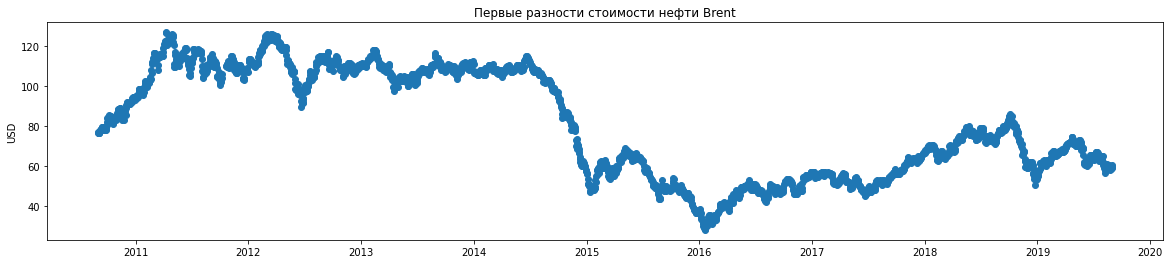

In [8]:
# Посмотрим, что получилось
plt.figure(figsize =(20,4))
plt.plot( brent_data.index, brent_data['Значение'], 'o' )
plt.title('Первые разности стоимости нефти Brent' )
plt.ylabel ( 'USD' )
plt.show()

In [9]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0.0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0.0   
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,first_val,t4,t3,t2,d4,d3,d2
Дата,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,0.00,0.00,0.00,0.52,0.00,0.00
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,0.00,0.00,0.00,-0.32,-0.32,0.00
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,0.00,0.00,0.00,0.05,0.05,0.05
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,0.00,0.00,0.00,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0,1.33,60.05,58.94,57.81,1.33,1.33,1.33
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0,0.25,58.94,57.81,58.26,0.25,0.25,0.25
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0,0.53,57.81,58.26,59.59,0.53,0.53,0.53


2. Добавьте первые разности по стоимости доллара и евро к рублю

In [10]:
# Прочитаем файл USD
path_usd = '~/Yandex.Disk/geekbrains/Python/MLInBusines/lesson_5/RC_F01_09_2010_T01_09_2019.xlsx'
rub_doll=pd.read_excel(path_usd)
rub_doll.index = pd.to_datetime(rub_doll['data'].values)
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [11]:
# Прочитаем файл EUR
path_eur = '~/Yandex.Disk/geekbrains/Python/MLInBusines/lesson_5/R_E01_09_2010_T01_09_2019.xlsx'
rub_e=pd.read_excel(path_eur)
rub_e.index = pd.to_datetime(rub_e['data'].values)
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [12]:
# Посчитаем первые разности для значений USD
brent_data['USD_f']=0.0
brent_data['USD_f'].values[1:2228]=rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
# Посчитаем первые разности для значений EUR
brent_data['EUR_f']=0.0
brent_data['EUR_f'].values[1:2228]=rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
brent_data=brent_data.iloc[:2228,:]
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,first_val,t4,t3,t2,d4,d3,d2,USD_f,EUR_f
Дата,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,0.00,0.00,0.00,0.52,0.00,0.00,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,0.00,0.00,0.00,-0.32,-0.32,0.00,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,0.00,0.00,0.00,0.05,0.05,0.05,0.0064,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,0.00,0.00,0.00,0.01,0.01,0.01,-0.1151,0.1215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-28,69.00,2018,3,28,1,87,13,2,0,0,0,0.11,70.36,69.85,69.52,0.11,0.11,0.11,0.3689,0.7712
2018-03-29,69.35,2018,3,29,1,88,13,3,0,0,0,0.35,69.85,69.52,68.89,0.35,0.35,0.35,0.2873,0.2136
2018-04-01,69.51,2018,4,1,2,91,13,6,0,0,0,0.16,69.52,68.89,69.00,0.16,0.16,0.16,0.1519,0.0492


3. Сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [13]:
# Пропустил
# Делаем ресемплинг по неделям и объеденяем все в один DataFrame
brent_first_w = brent_data.resample('W').mean()
brent_first_w = brent_first_w.dropna()
brent_first_w.head(10)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,first_val,t4,t3,t2,d4,d3,d2,USD_f,EUR_f
Дата,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.200000,0.000000,0.052000,0.000000,0.000000,0.000000,0.052000,-0.052000,0.012000,-0.057960,0.091860
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.000000,0.166667,0.288333,76.806667,76.980000,77.086667,0.288333,0.288333,0.288333,0.021300,0.009067
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.000000,0.000000,-0.021667,78.366667,78.578333,78.788333,-0.021667,-0.021667,-0.021667,0.046283,0.283167
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.000000,0.000000,0.118333,78.555000,78.351667,78.261667,0.118333,0.118333,0.118333,-0.078333,0.035633
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.000000,0.000000,0.791667,78.440000,78.888333,79.585000,0.791667,0.791667,0.791667,-0.100667,0.038750
2010-10-10,84.146667,2010.0,10.000000,6.666667,4.000000,279.666667,40.0,2.666667,0.000000,0.166667,0.000000,0.106667,83.038333,83.810000,83.976667,0.106667,0.106667,0.106667,0.102517,0.114333
2010-10-17,83.498333,2010.0,10.000000,13.666667,4.000000,286.666667,41.0,2.666667,0.166667,0.000000,0.166667,-0.301667,83.963333,83.886667,84.038333,-0.301667,-0.301667,-0.301667,-0.020617,0.018017
2010-10-24,82.795000,2010.0,10.000000,20.666667,4.000000,293.666667,42.0,2.666667,0.000000,0.000000,0.000000,0.071667,83.228333,83.030000,82.700000,0.071667,0.071667,0.071667,0.061817,0.116600
2010-10-31,83.361667,2010.0,10.000000,27.666667,4.000000,300.666667,43.0,2.666667,0.000000,0.000000,0.000000,0.051667,83.070000,83.018333,83.270000,0.051667,0.051667,0.051667,0.011750,-0.155717


In [14]:
# Пропустил
# Удаляем неактуальные данные и округляем проазничные предпраздничные дни, может пригодится
brent_first_w.drop(['dayofweek'], axis=1, inplace=True)
brent_first_w = brent_first_w.round({'month': 0, 'quarter': 0})
brent_first_w['is_holiday'] =  my_round(brent_first_w['is_holiday'], 0)
brent_first_w['is_prev_holiday'] =  my_round(brent_first_w['is_prev_holiday'], 0)
brent_first_w['is_next_holiday'] =  my_round(brent_first_w['is_next_holiday'], 0)

4. Постройте модель предсказания 1-й точки от текущей (h=1).

brent_first_w = brent_first.copy()

In [15]:
# Стандартизируем наши данные и делаем горизинт предсказания h=1
scl_target=StandardScaler() 
h=1
target = brent_first_w['Значение'].values[h:].reshape((brent_first_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(395, 1)

In [16]:
scl_x=StandardScaler() 

X = brent_first_w.iloc[:-h,:].values
# X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(395, 19)

Отбираем наилучшие признаки

In [17]:
f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=60776.93,  I=0
F-test=620.49,  I=1
F-test=0.50,  I=2
F-test=0.02,  I=3
F-test=0.32,  I=4
F-test=0.41,  I=5
F-test=0.39,  I=6
F-test=0.07,  I=7
F-test=1.13,  I=8
F-test=0.01,  I=9
F-test=1.31,  I=10
F-test=11745.42,  I=11
F-test=12481.58,  I=12
F-test=13377.85,  I=13
F-test=1.31,  I=14
F-test=1.32,  I=15
F-test=1.32,  I=16
F-test=0.84,  I=17
F-test=0.25,  I=18


In [18]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(395, 5)

In [19]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(395, 2)

In [20]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(395, 1)

In [21]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  1 11 12 13]
Номера признаков лучших признаков по процентной форме:  [ 0 13]
Номера признаков для выбора по модели :  [0]


In [22]:
# Объединяем признаки
list_par = list(list_param_k.copy())
list_par.extend(list(list_param_p))
list_par.extend(list(list_param_m))
list_par = list(set(list_par))
print(list_par)

[0, 1, 11, 12, 13]


In [23]:
X_new = X[:,list_par]

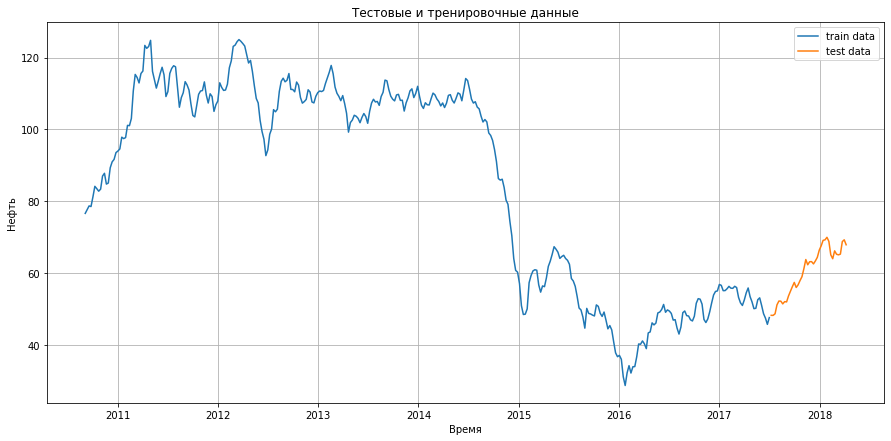

In [24]:
train, test = split_data(brent_first_w, -40)
# train, test = split_data( brent_first_w[-2000:], -100)
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [25]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [26]:
print(len(X_train), len(X_test))

356 39


In [27]:
# Тренируем модель и делаем предсказание
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_g.fit(X_train, y_train)
y_pred_g = model_g.predict(X_train)
y_test_pred_g = model_g.predict(X_test)

In [28]:
# Посмотрим ошибку нашего предсказания
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.1772750245424204 %


In [29]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.007606233793664266 
ошибка mae  :   0.06942292529999838 
оценка R2 :   0.8573825375605653


In [30]:
param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

/home/aleksandr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Model with rank: 1
Mean validation score: 0.769 (std: 0.144)
Parameters: {'n_estimators': 200, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.764 (std: 0.146)
Parameters: {'n_estimators': 300, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.764 (std: 0.137)
Parameters: {'n_estimators': 200, 'max_depth': 4}



In [31]:
# Тренируем модель и делаем предсказание
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=200)
model_g.fit(X_train, y_train)
y_pred_g = model_g.predict(X_train)
y_test_pred_g = model_g.predict(X_test)

In [32]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.007208089078661211 
ошибка mae  :   0.06864599855198406 
оценка R2 :   0.8648477812643158


In [33]:
# Посмотрим ошибку нашего предсказания
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.144632495005417 %


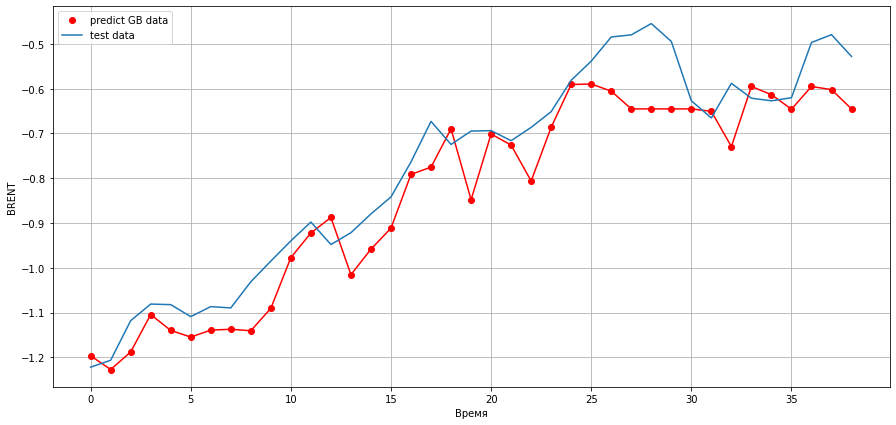

In [34]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.